# Table of contents
1. [Requirements](#Requirements)
2. [Introduction](#Introduction)
3. [Imports](#Imports)
    1. [Libraries](#Libraries)
    2. [Data](#Data)
4. [Data Exploration](#data-exploration)
5. [Modelling](#modelling)
    1. [Baseline](#baseline)
    2. [LSTM](#lstm)
6. [Results Analysis](#results-analysis)

# Requirements

In [ ]:
!pip install kerastuner

## Introduction

## Imports

### Libraries


In [11]:
import sympy
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import numpy as np
import kerastuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from datetime import datetime

In [22]:
import matplotlib.pyplot as plt

### Data

In [12]:
# Load the data
worksheet_EnergyConsumption = pd.read_csv('consumption.csv')
worksheet_Weather = pd.read_csv('weather.csv')

In [14]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table


In [15]:
missing_zero_values_table(worksheet_EnergyConsumption)

Your selected dataframe has 8 columns and 43823 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PT_wind_generation_actual,0,43823,100.0,43823,100.0,float64
PT_wind_offshore_generation_actual,0,43823,100.0,43823,100.0,float64
PT_solar_generation_actual,20263,8,0.0,20271,46.3,float64
PT_load_actual_entsoe_transparency,0,1,0.0,1,0.0,float64
PT_load_forecast_entsoe_transparency,0,1,0.0,1,0.0,float64
PT_wind_onshore_generation_actual,0,1,0.0,1,0.0,float64


In [16]:
missing_zero_values_table(worksheet_Weather)

Your selected dataframe has 4 columns and 43823 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [17]:
# Transform timestamp datatype
worksheet_EnergyConsumption["utc_timestamp"] = pd.to_datetime(worksheet_EnergyConsumption["utc_timestamp"])
worksheet_Weather["utc_timestamp"] = pd.to_datetime(worksheet_Weather["utc_timestamp"])

# As seguintes colunas estão todas NaN, não são uteis. The remaining columns are removed since they aren't usefull.
worksheet_EnergyConsumption.drop([
    "cet_cest_timestamp",
    "PT_wind_generation_actual",
    "PT_wind_offshore_generation_actual",
    "PT_wind_onshore_generation_actual",
    "PT_solar_generation_actual"
], axis=1, inplace=True)

# Bfill 
worksheet_EnergyConsumption["PT_load_forecast_entsoe_transparency"] = worksheet_EnergyConsumption["PT_load_forecast_entsoe_transparency"].bfill()
worksheet_EnergyConsumption["PT_load_actual_entsoe_transparency"] = worksheet_EnergyConsumption["PT_load_actual_entsoe_transparency"].bfill()

In [18]:
df=pd.merge(worksheet_EnergyConsumption, worksheet_Weather, on="utc_timestamp")

In [21]:
df

,utc_timestamp,PT_load_actual_entsoe_transparency,PT_load_forecast_entsoe_transparency,PT_temperature,PT_radiation_direct_horizontal,PT_radiation_diffuse_horizontal,Day sin,Day cos,Year sin,Year cos
0,2015-01-01 00:00:00+00:00,5123.9,NaN,5.584,0.000000,0.000000,1.232357e-12,1.000000e+00,0.001505,0.999999
1,2015-01-01 01:00:00+00:00,5123.9,4820.0,5.219,0.000000,0.000000,2.588190e-01,9.659258e-01,0.002222,0.999998
2,2015-01-01 02:00:00+00:00,4771.1,4521.0,5.034,0.000000,0.000000,5.000000e-01,8.660254e-01,0.002939,0.999996
3,2015-01-01 03:00:00+00:00,4443.5,4250.0,4.708,0.000000,0.000000,7.071068e-01,7.071068e-01,0.003656,0.999993
4,2015-01-01 04:00:00+00:00,4234.9,4083.0,4.353,0.000000,0.000000,8.660254e-01,5.000000e-01,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...
43818,2019-12-31 18:00:00+00:00,6894.4,6427.0,10.170,0.012284,0.151716,-1.000000e+00,-5.106998e-12,-0.006451,0.999979
43819,2019-12-31 19:00:00+00:00,6788.8,6351.0,9.646,0.000000,0.000000,-9.659258e-01,2.588190e-01,-0.005734,0.999984
43820,2019-12-31 20:00:00+00:00,6193.0,5852.0,9.172,0.000000,0.000000,-8.660254e-01,5.000000e-01,-0.005017,0.999987
43821,2019-12-31 21:00:00+00:00,5706.9,5345.0,8.705,0.000000,0.000000,-7.071068e-01,7.071068e-01,-0.004301,0.999991


In [19]:
date_time=worksheet_EnergyConsumption["utc_timestamp"].copy()
timestamp_s=date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


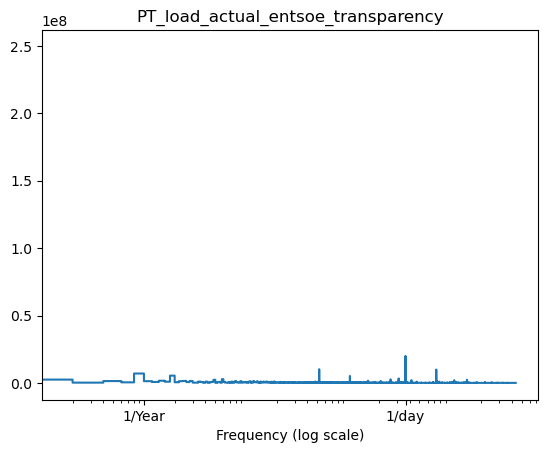

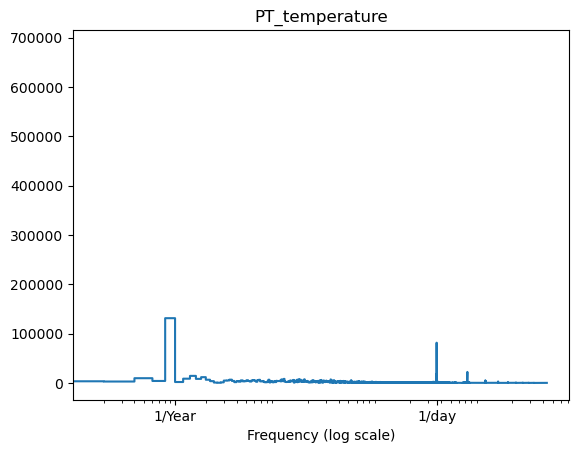

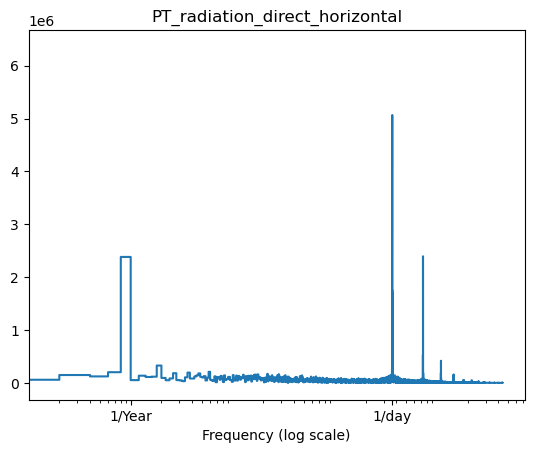

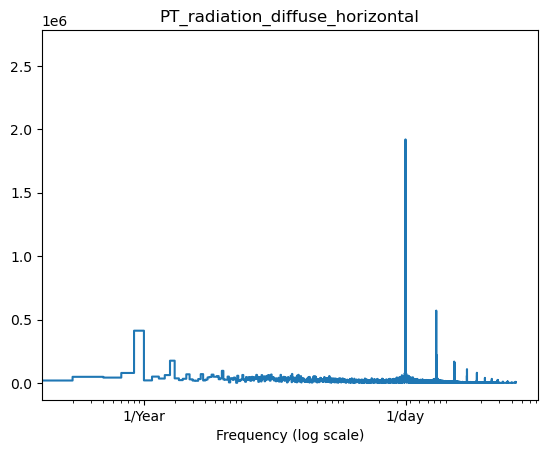

In [25]:
# para confirmar a periocidade através da FFT.
def plot_fft(df):
    columns=df.columns
    for col in columns:
        values=df[col].values
        fft=np.fft.fft(values)
        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = len(df[col])
        hours_per_year = 24*365.2524
        years_per_dataset = n_samples_h/(hours_per_year)

        f_per_year = f_per_dataset/years_per_dataset
        plt.figure()
        plt.step(f_per_year, np.abs(fft))
        plt.xscale('log')
        
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
        _ = plt.xlabel('Frequency (log scale)')
        plt.title(col)

    plt.show()
df_copy=df.loc[:,["PT_load_actual_entsoe_transparency","PT_temperature","PT_radiation_direct_horizontal","PT_radiation_diffuse_horizontal"]]
plot_fft(df_copy)

In [20]:
df

,utc_timestamp,PT_load_actual_entsoe_transparency,PT_load_forecast_entsoe_transparency,PT_temperature,PT_radiation_direct_horizontal,PT_radiation_diffuse_horizontal,Day sin,Day cos,Year sin,Year cos
0,2015-01-01 00:00:00+00:00,5123.9,NaN,5.584,0.000000,0.000000,1.232357e-12,1.000000e+00,0.001505,0.999999
1,2015-01-01 01:00:00+00:00,5123.9,4820.0,5.219,0.000000,0.000000,2.588190e-01,9.659258e-01,0.002222,0.999998
2,2015-01-01 02:00:00+00:00,4771.1,4521.0,5.034,0.000000,0.000000,5.000000e-01,8.660254e-01,0.002939,0.999996
3,2015-01-01 03:00:00+00:00,4443.5,4250.0,4.708,0.000000,0.000000,7.071068e-01,7.071068e-01,0.003656,0.999993
4,2015-01-01 04:00:00+00:00,4234.9,4083.0,4.353,0.000000,0.000000,8.660254e-01,5.000000e-01,0.004372,0.999990
...,...,...,...,...,...,...,...,...,...,...
43818,2019-12-31 18:00:00+00:00,6894.4,6427.0,10.170,0.012284,0.151716,-1.000000e+00,-5.106998e-12,-0.006451,0.999979
43819,2019-12-31 19:00:00+00:00,6788.8,6351.0,9.646,0.000000,0.000000,-9.659258e-01,2.588190e-01,-0.005734,0.999984
43820,2019-12-31 20:00:00+00:00,6193.0,5852.0,9.172,0.000000,0.000000,-8.660254e-01,5.000000e-01,-0.005017,0.999987
43821,2019-12-31 21:00:00+00:00,5706.9,5345.0,8.705,0.000000,0.000000,-7.071068e-01,7.071068e-01,-0.004301,0.999991


In [ ]:
# Load the data

# Split the data
X_train, y_train, X_val, y_val = load_data(hourly_energy_consumption, hourly_temperature, hourly_radiation)


## Data Exploration

## Modelling

In [ ]:
# Aqui tratar de qualquer operação ou criação de variáveis que sejam
# necessárias para o processo de modelação de DL.
# Number of samples
n_samples = len(hourly_energy_consumption)

# Number of time steps
n_timesteps = 24
# Number of features
n_features = 3
# Reshape the data into a 3D array to feed the Neural Netwokrs
X = np.empty((n_samples, n_timesteps, n_features))
X[:, :, 0] = hourly_energy_consumption
X[:, :, 1] = hourly_temperature
X[:, :, 2] = hourly_radiation

### Baseline
        Persistence

A persistência é o método de baseline mais condiserado e que, como o nome indica, considera que o valor para o futuro é igual à ultima observação. Pode ser denotado pela seguinte equação:

$ T_{t+1} = T_{t} $ 

In [ ]:
# creating the persistence matrix
# df.merged.shape should be Amount of predictions we want to gather X 24
persistence_forecasts=np.zeros((dfmerged.shape),dtype=float)
for i in range(len(dfmerged)):
    persistence_forecasts.iloc[i,:]=dfmerged.iloc[i,-1]

### LSTM

In [ ]:
# Define the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(24))
    
    # Choose an optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd','rmsprop'])
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    else:    
        optimizer = tf.keras.optimizers.RMSprop(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
        
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
# Define the search space for Keras Tuner
hps = HyperParameters()
hps.Choice('batch_size', [32, 64, 128, 256])
hps.Choice('activation', ['relu', 'tanh','sigmoid'])
# Use the Keras Tuner to search for the best set of hyperparameters
tuner = kt.Hyperband(build_model, hps)
tuner.search(X_train, y_train, epochs=100,batch_size=1, validation_data=(X_val, y_val))
# Get the best model from the search
best_model = tuner.get_best_model()
# Use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)


## Results Analysis